In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.pipeline.data_io import get_existing_sessions, get_session_selection, SessionDirectory
from toolkit.analysis.statistics import quantize_nd, statistic_in_grid
from toolkit.plots.plots import heatmap_in_grid

## Config

In [2]:
config_name = 'mixed_stimuli_RS_units_all_layers'

In [12]:
session_set = 'all'  # 'all', 'selected', 'test'

ecephys_structure_acronym = GLOBAL_SETTINGS['ecephys_structure_acronym']

# get existing sessions in the data cache directory
session_list, missing_sessions = get_existing_sessions(session_set, structure_acronym=ecephys_structure_acronym)

sessions_df = get_session_selection().loc[session_list]
session_list = sessions_df.index[sessions_df['has_lfp_data']].tolist()

## Get heatmap data from session

In [4]:
power_dss = {}

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

    if not session_dir.exist:
        print(f"Failed to load session {session_id}: session directory does not exist")
    elif not session_dir.has_lfp_data: # skip if no lfp data
        print(f"Skip loading session {session_id}: no lfp data")
    else:
        power_dss[session_id] = session_dir.load_population_vector_data(config_name=config_name)

print("Variable names: ", power_dss[session_id].variable_name.values)

Variable names:  ['mean_fr' 'rms_fr' 'length' 'speed' 'angle' 'radial' 'tangent']


## Plot heatmaps

In [5]:
x_var = 'radial'
y_var = 'tangent'

n_bins = 10

figsize = (12, 5)

In [15]:
for session_id, power_ds in power_dss.items():
    n = np.isnan(power_ds.power.values).sum()
    p = n / power_ds.power.size
    if n > 0:
        print(f"Session {session_id} has {n} NaN values ({p:.2%})")

Session 715093703 has 28176 NaN values (17.10%)
Session 742951821 has 7198 NaN values (4.25%)
Session 840012044 has 27074 NaN values (13.74%)
Session 847657808 has 15540 NaN values (7.96%)


In [9]:
heatmap_ds = {}
for session_id, power_ds in power_dss.items():
    # get quantile grids and average power in grids
    power = power_ds.power.transpose('wave_band', 'sample').values
    idx_in_grid, (x_bins, y_bins), hist_count = quantize_nd([power_ds[x_var], power_ds[y_var]], n_bins=n_bins)
    power_avg, hist_count = statistic_in_grid(power, idx_in_grid, hist_counts=hist_count)

    heatmap_ds[session_id] = xr.Dataset(
        data_vars=dict(
            power=(('wave_band', 'x_bin', 'y_bin'), power_avg),
            hist_count=(('x_bin', 'y_bin'), hist_count)
        ),
        coords=dict(
            wave_band=power_ds.coords['wave_band'],
            x_edge=x_bins, y_edge=y_bins,
            x_bin=range(x_bins.size - 1), y_bin=range(y_bins.size - 1)
        )
    )

wave_bands = power_ds.coords['wave_band'].values
n_waves = wave_bands.size
xlabel, ylabel = power_ds.label.sel(variable_name=[x_var, y_var]).values
xticks_fmt, yticks_fmt = power_ds.fmt.sel(variable_name=[x_var, y_var]).values

C:\Users\chen8\AppData\Local\Temp\ipykernel_34840\705419003.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=figsize)


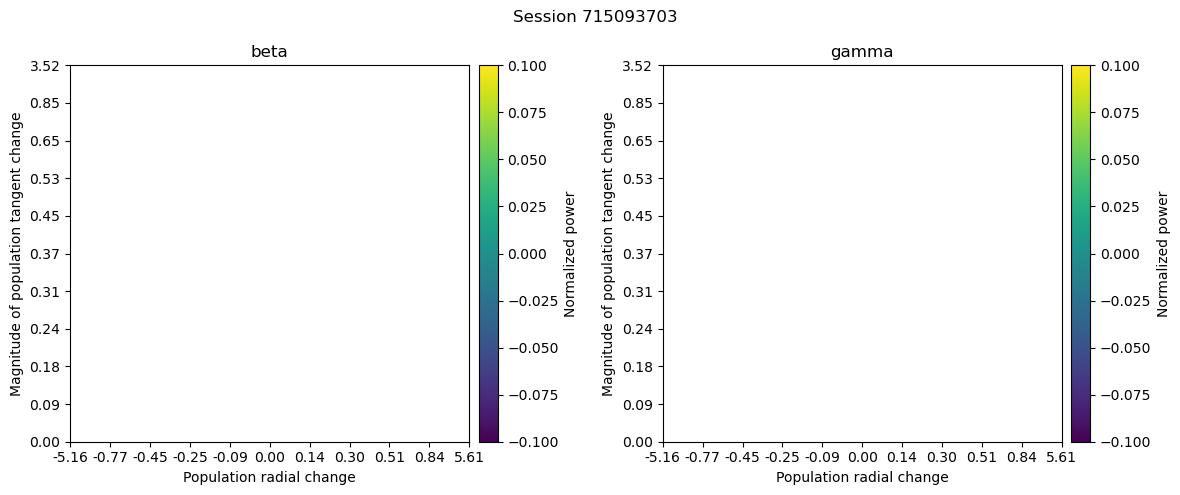

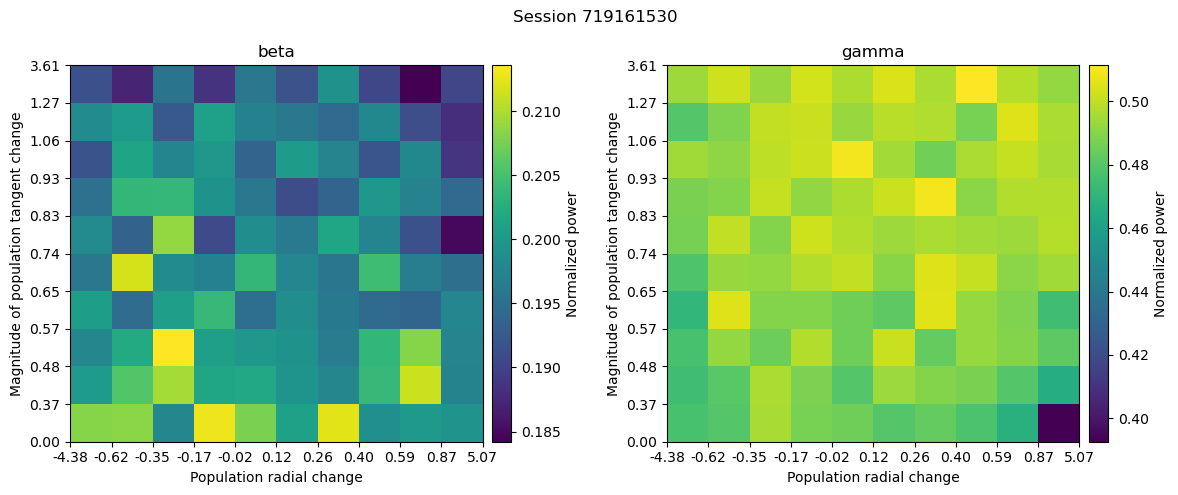

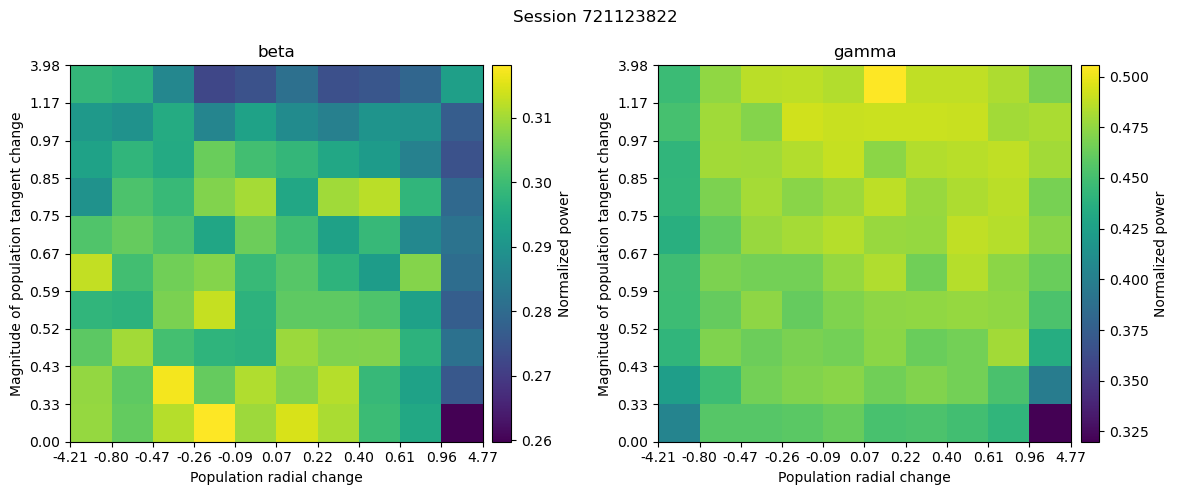

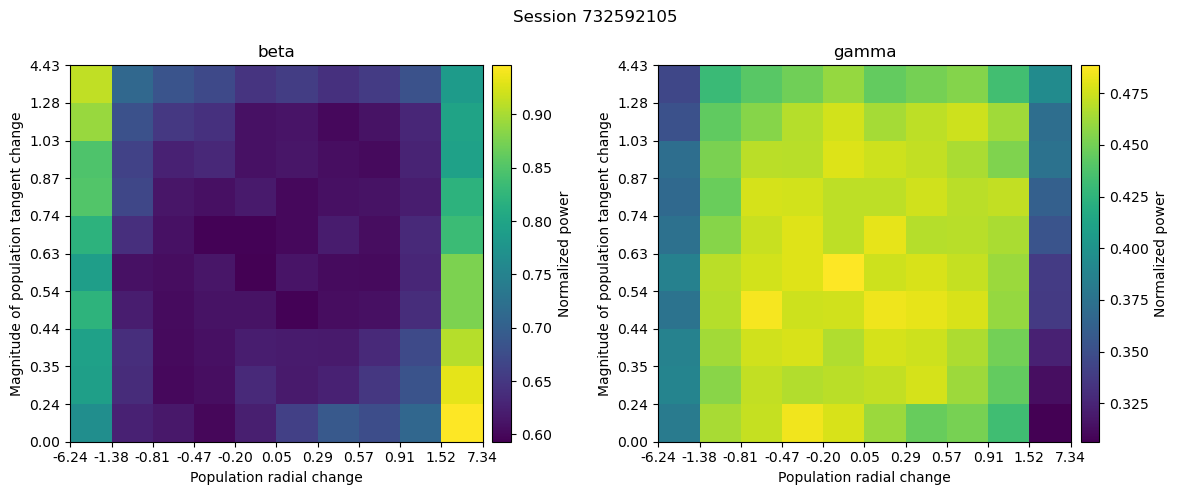

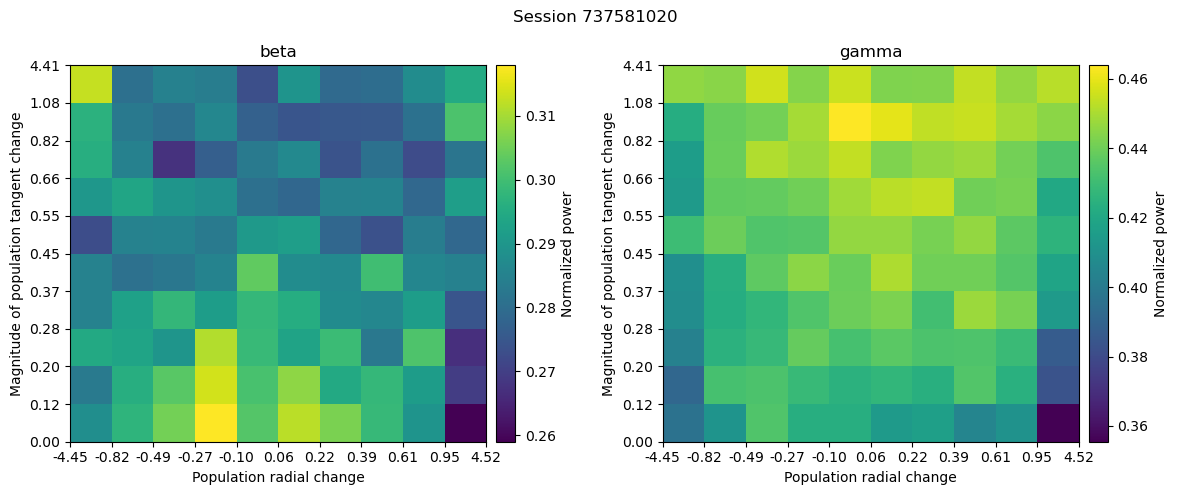

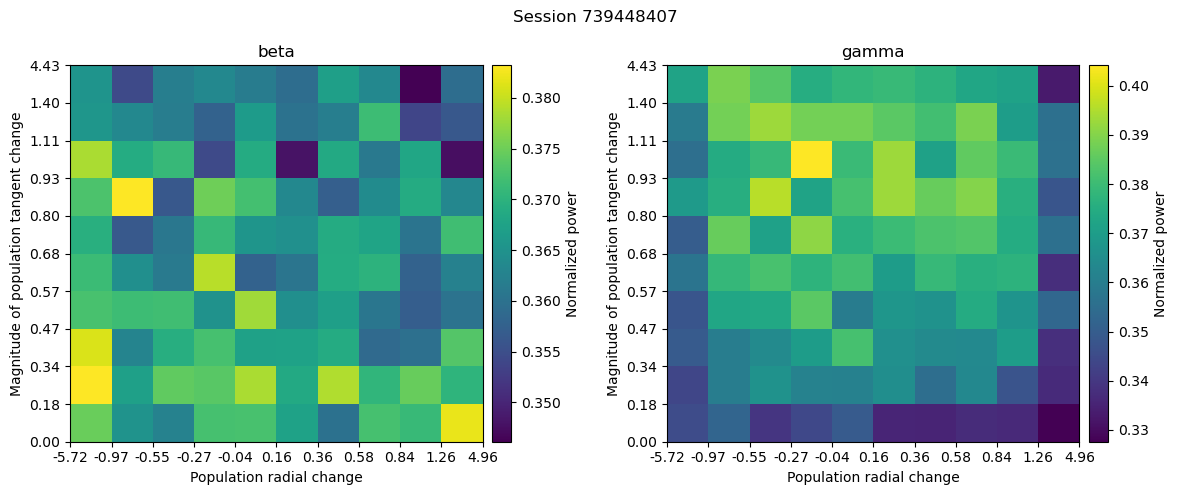

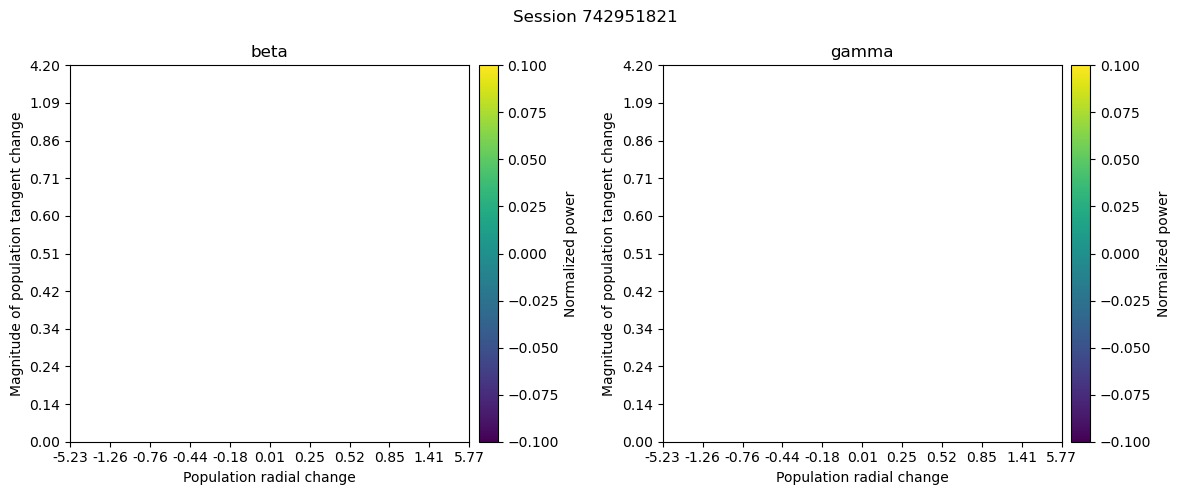

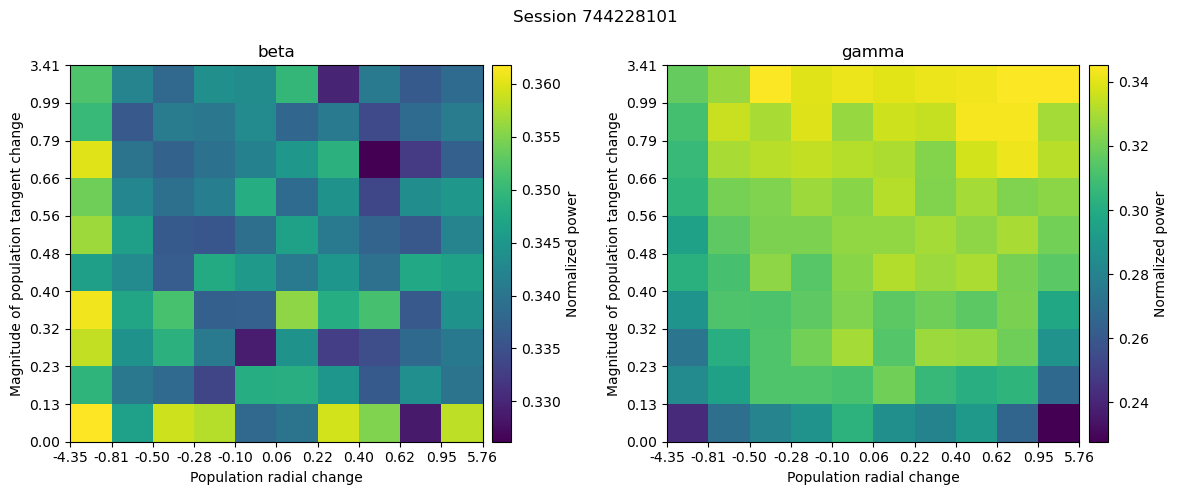

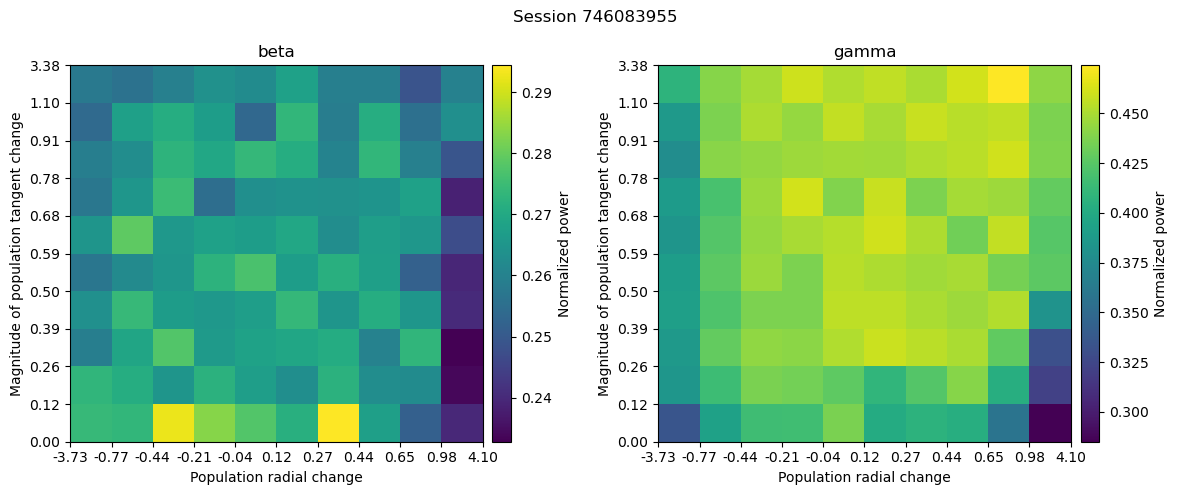

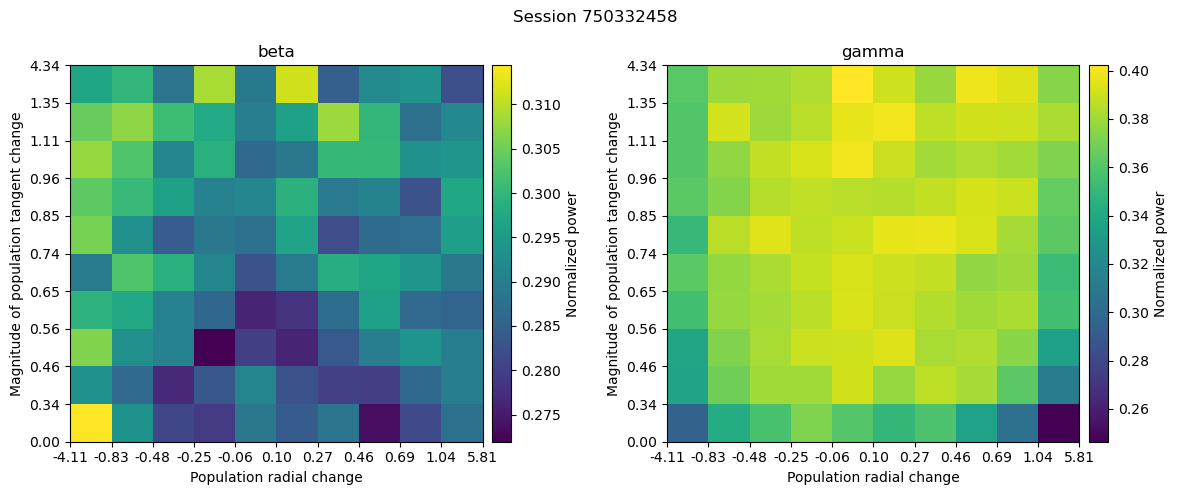

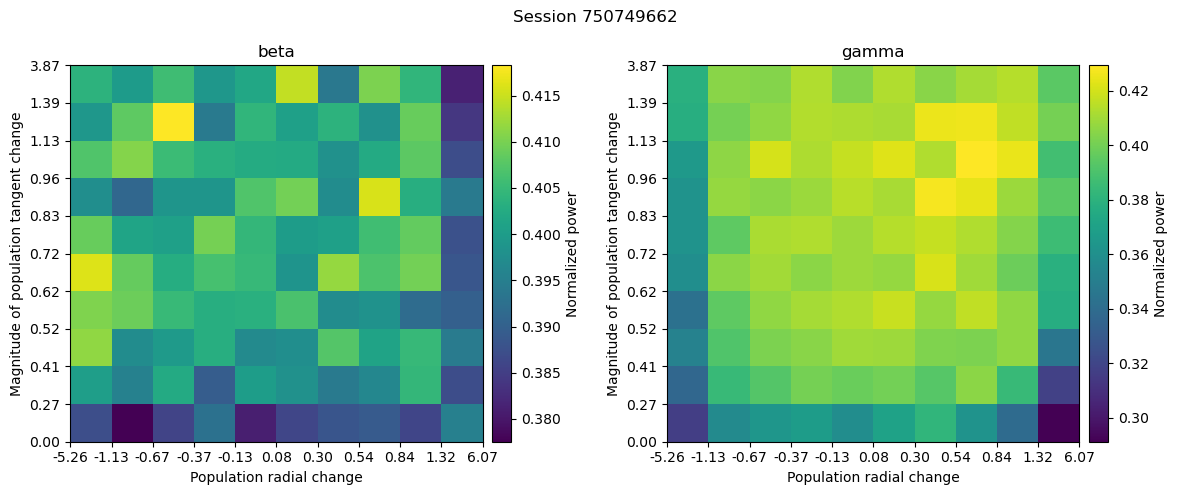

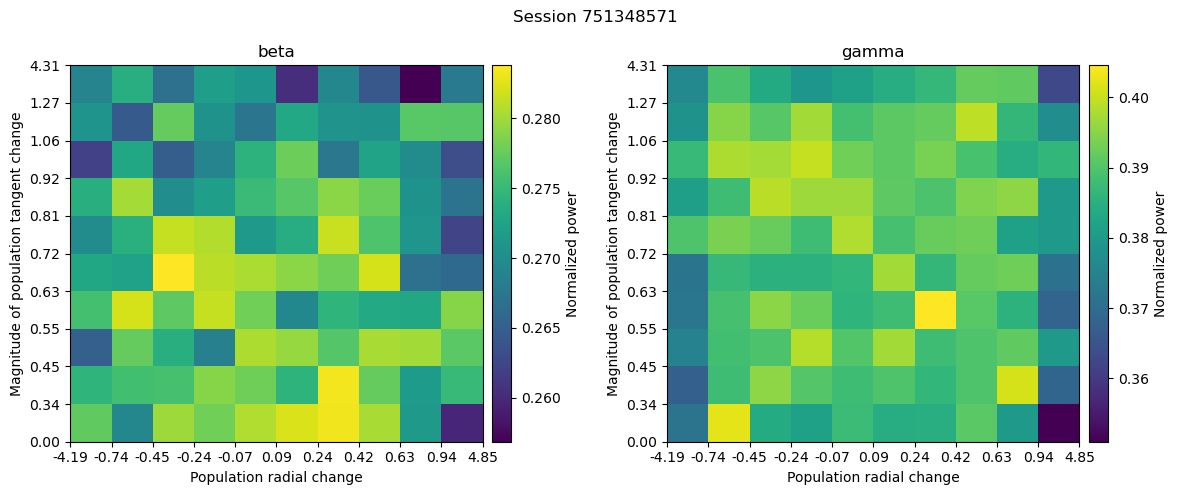

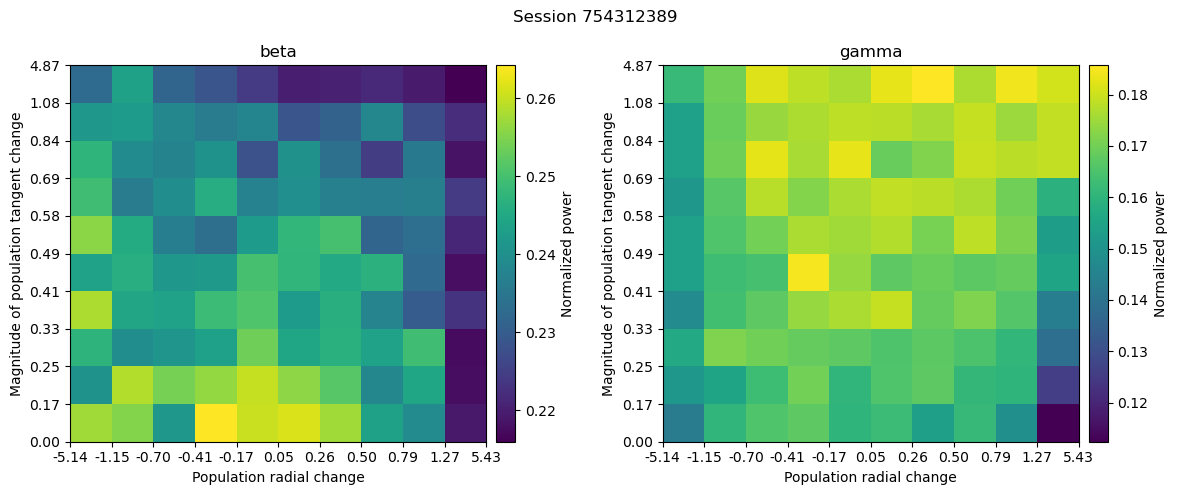

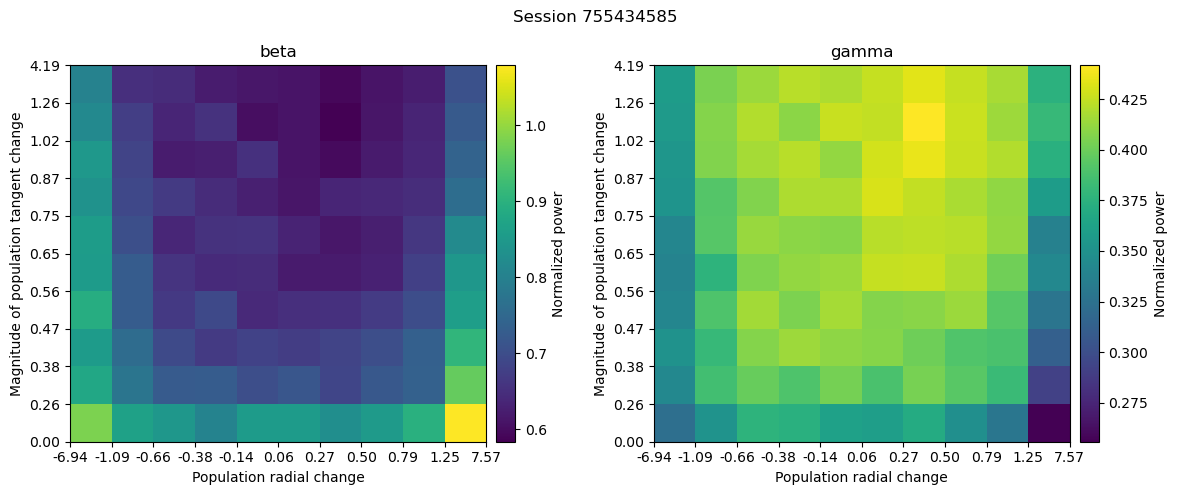

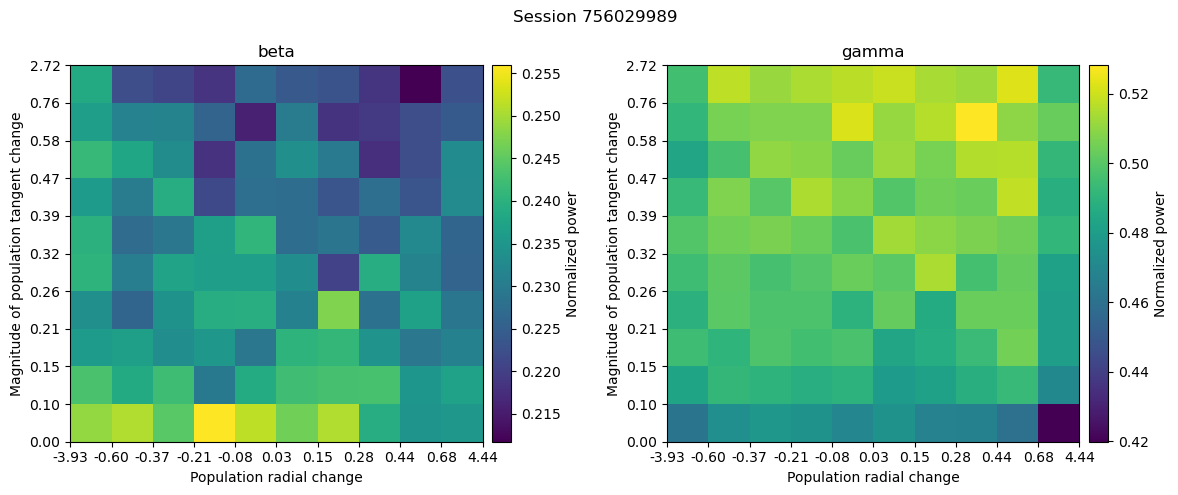

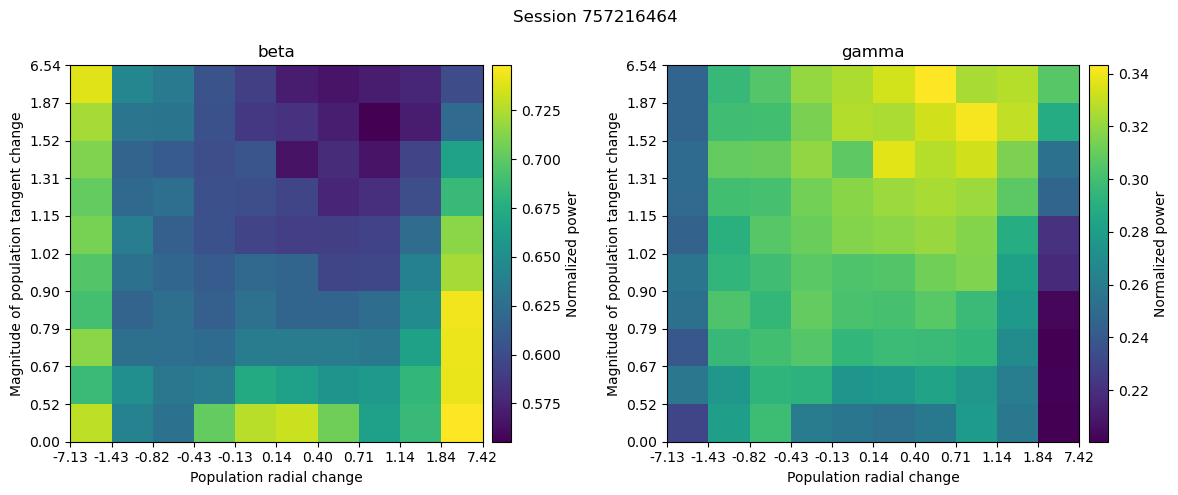

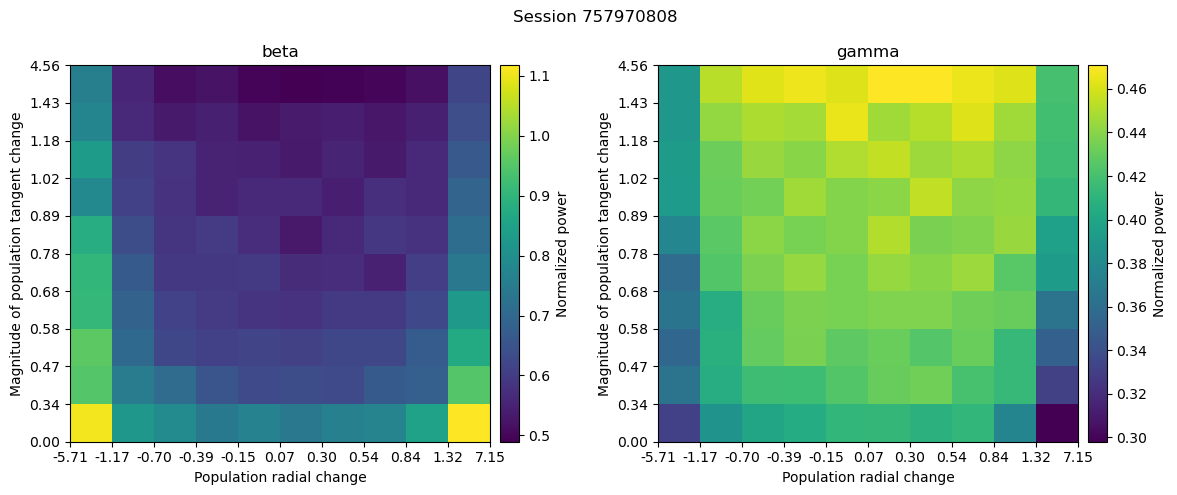

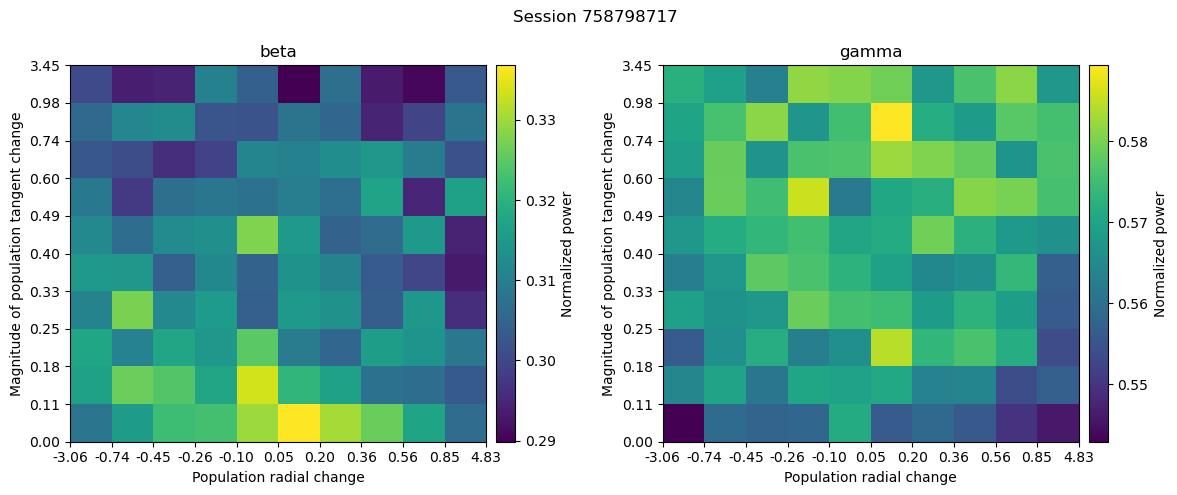

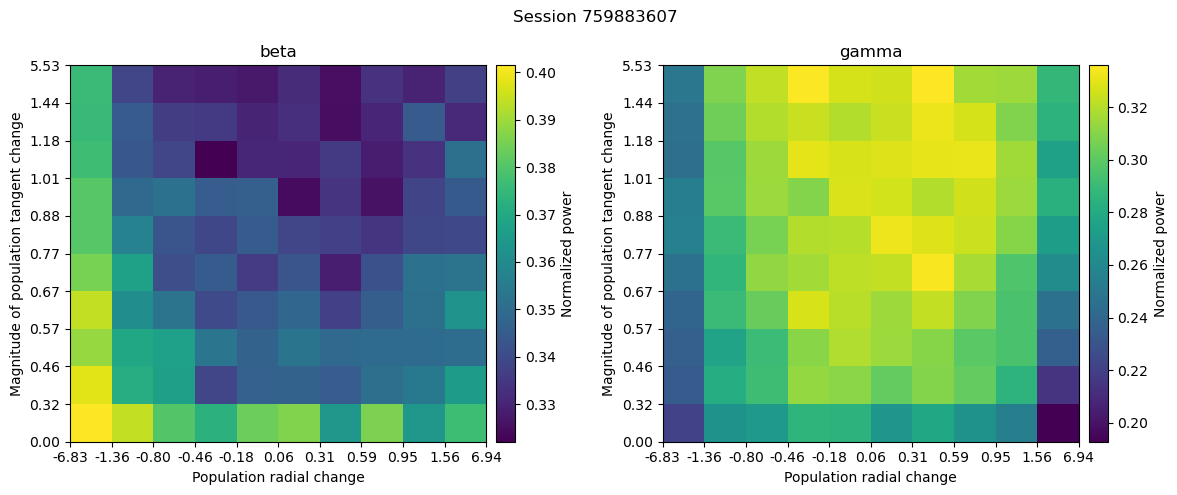

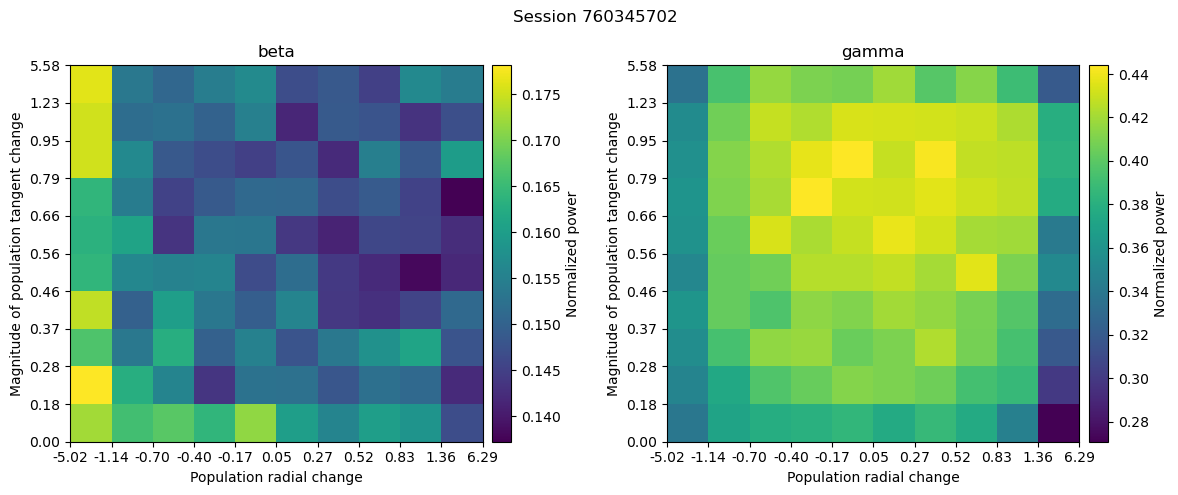

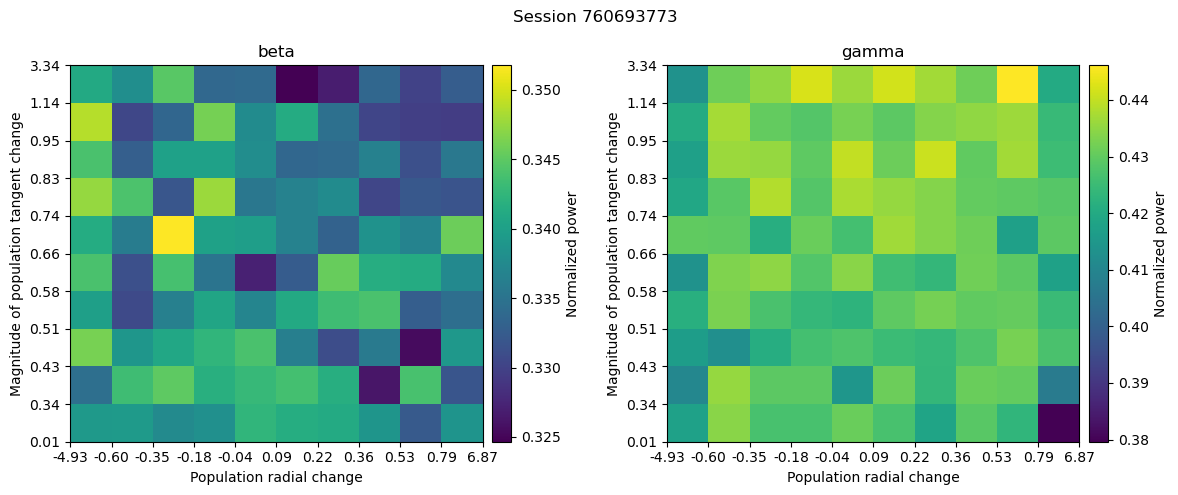

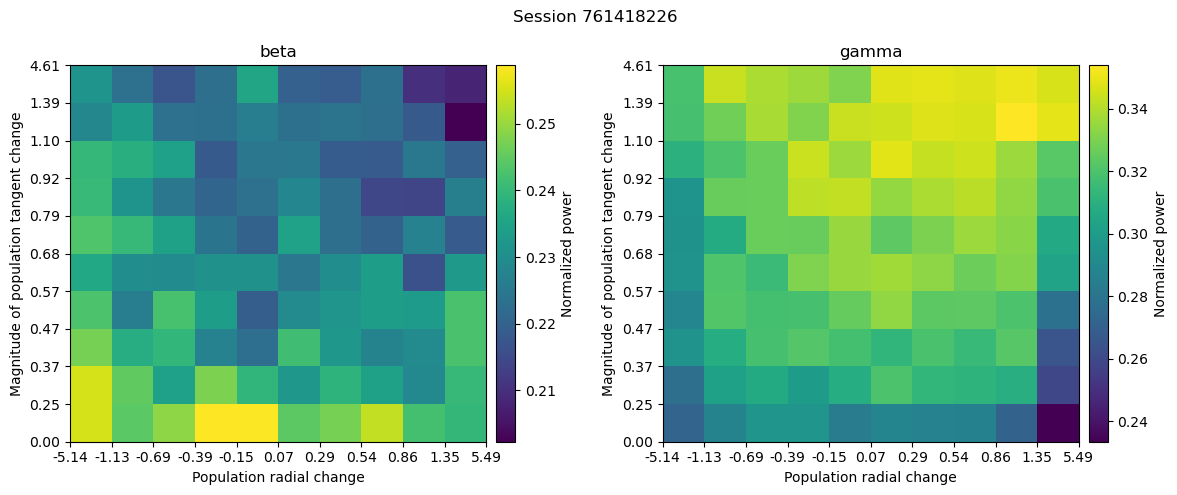

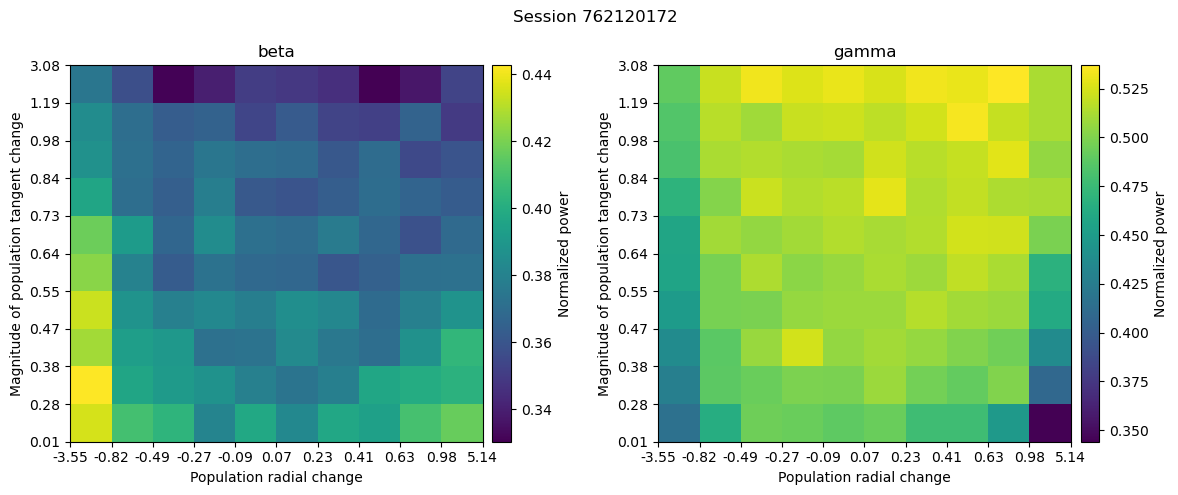

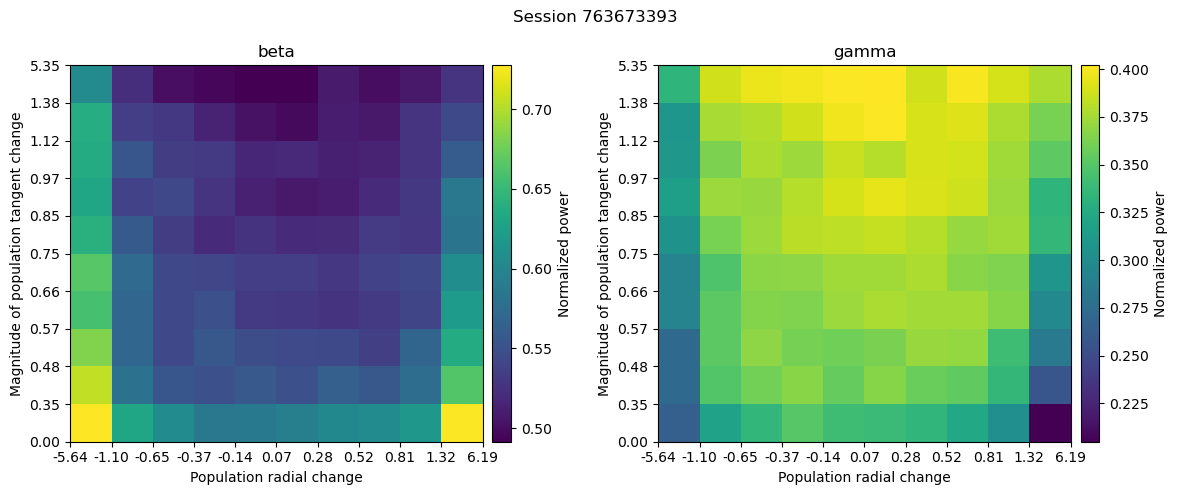

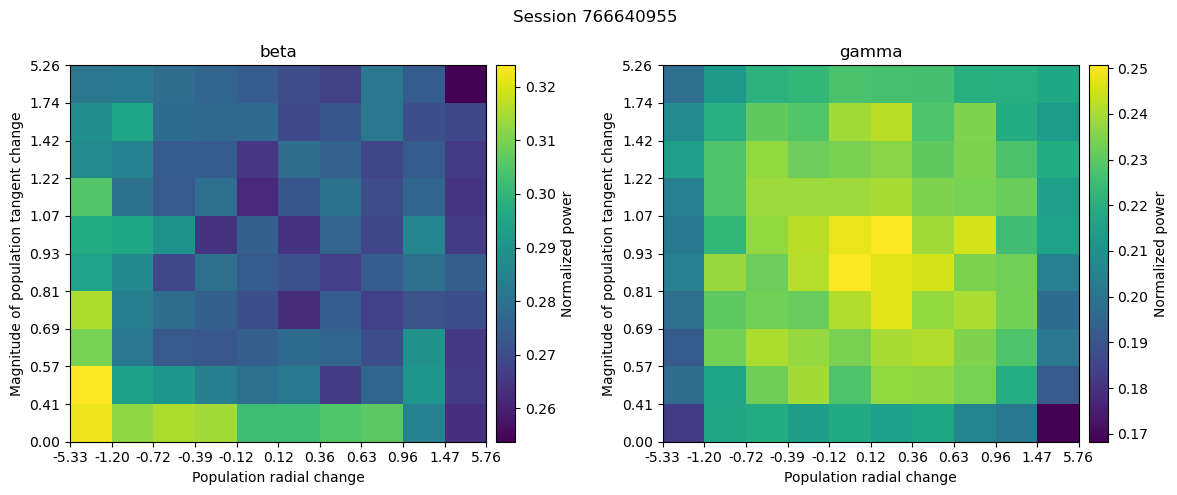

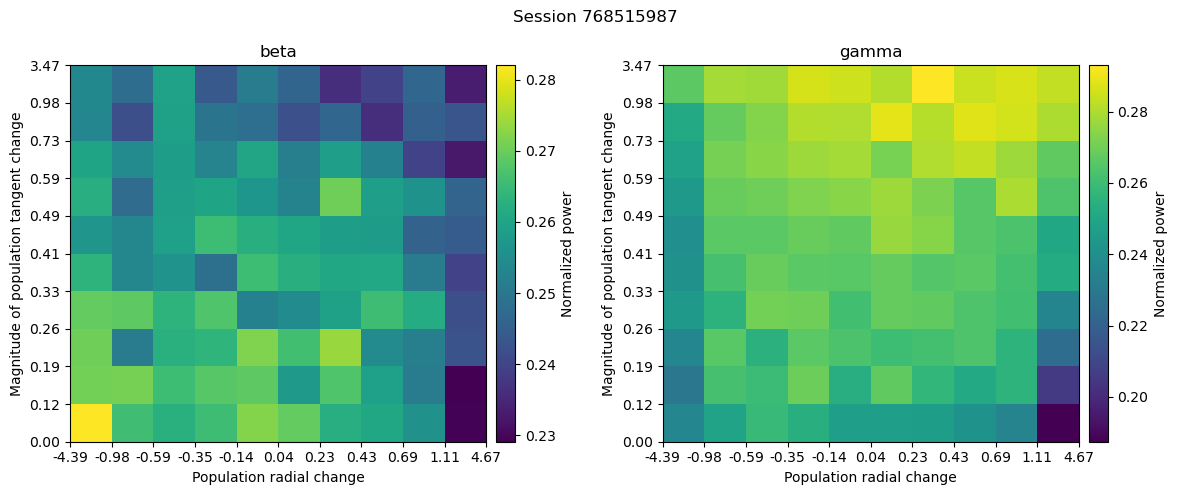

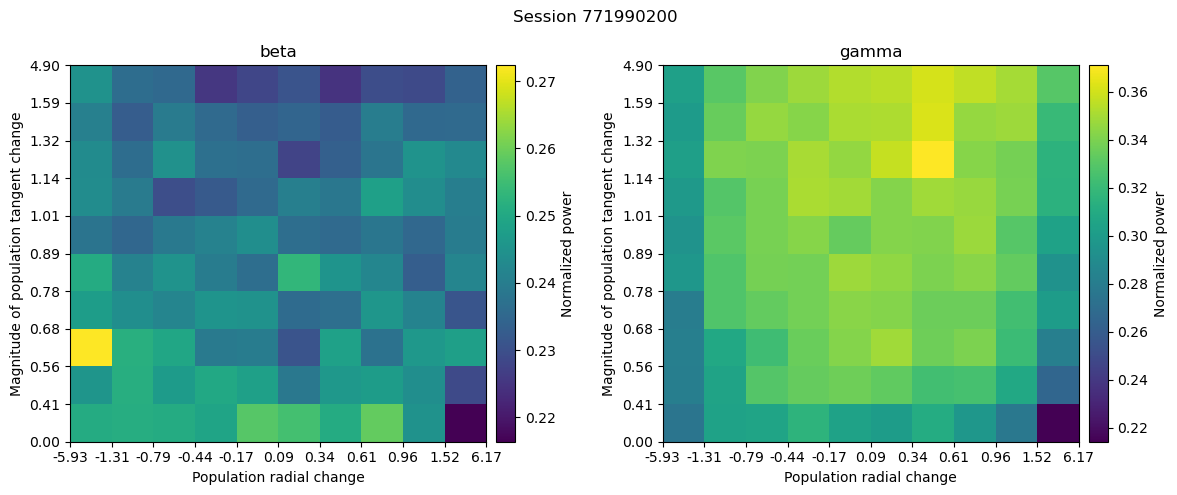

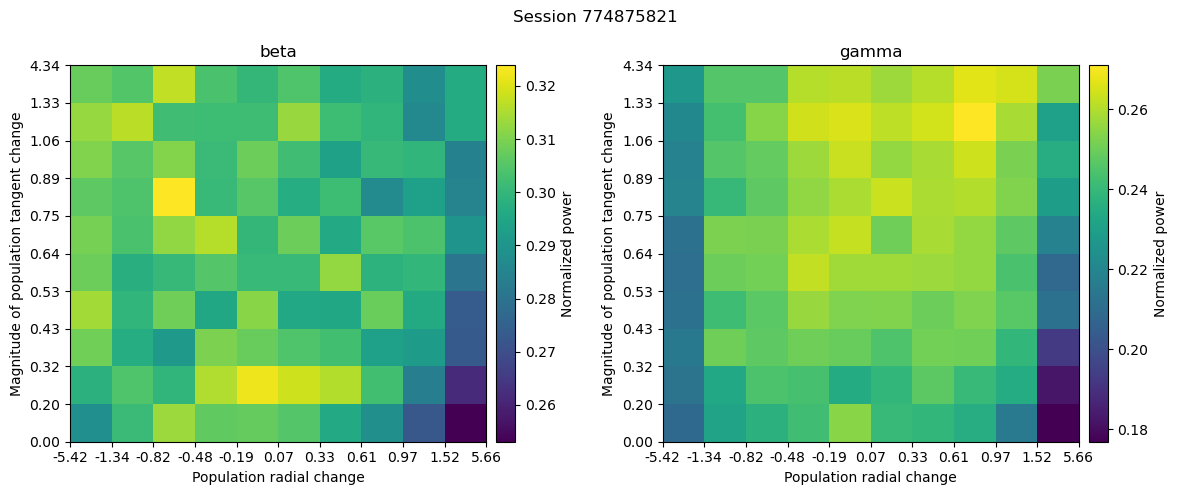

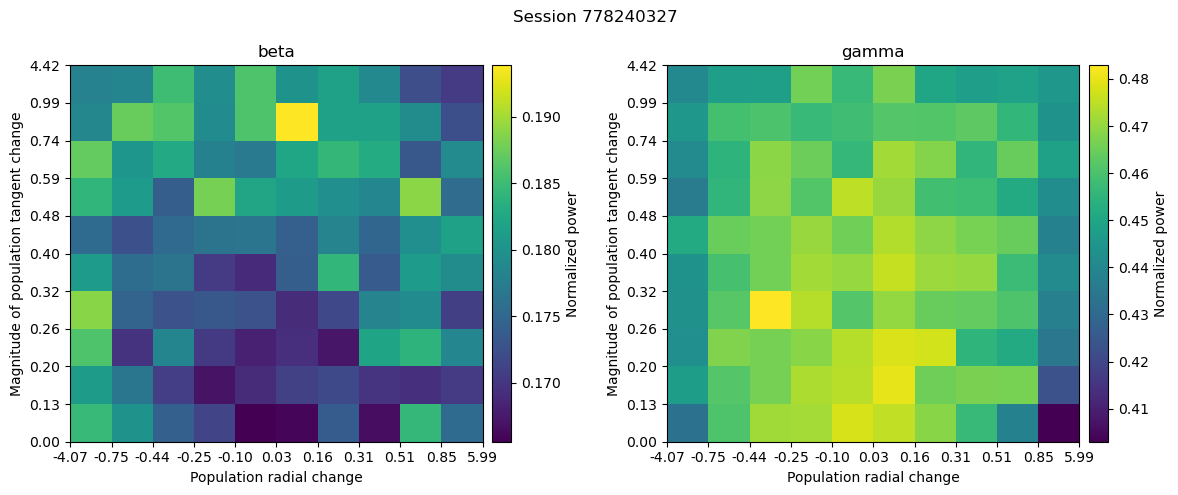

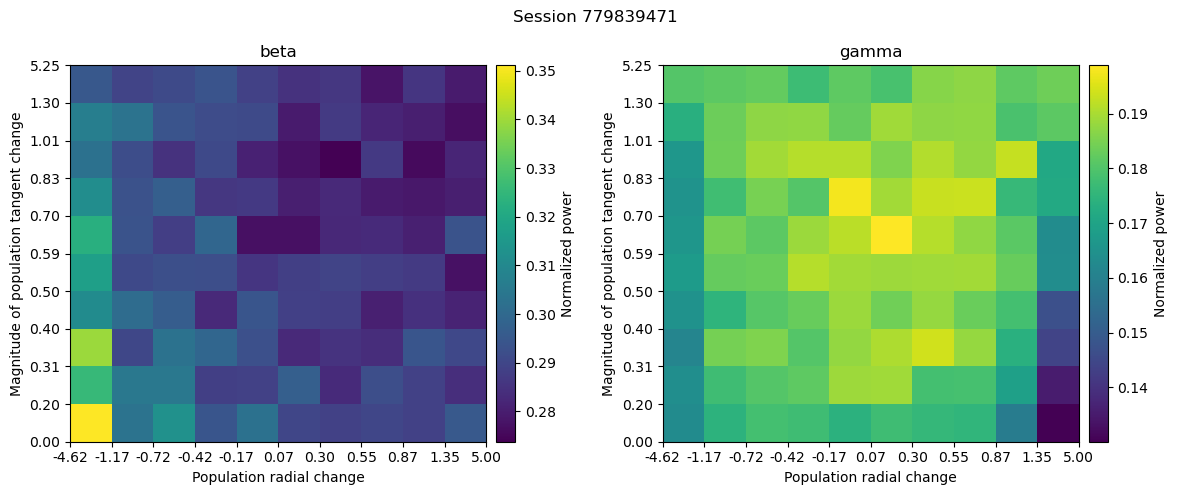

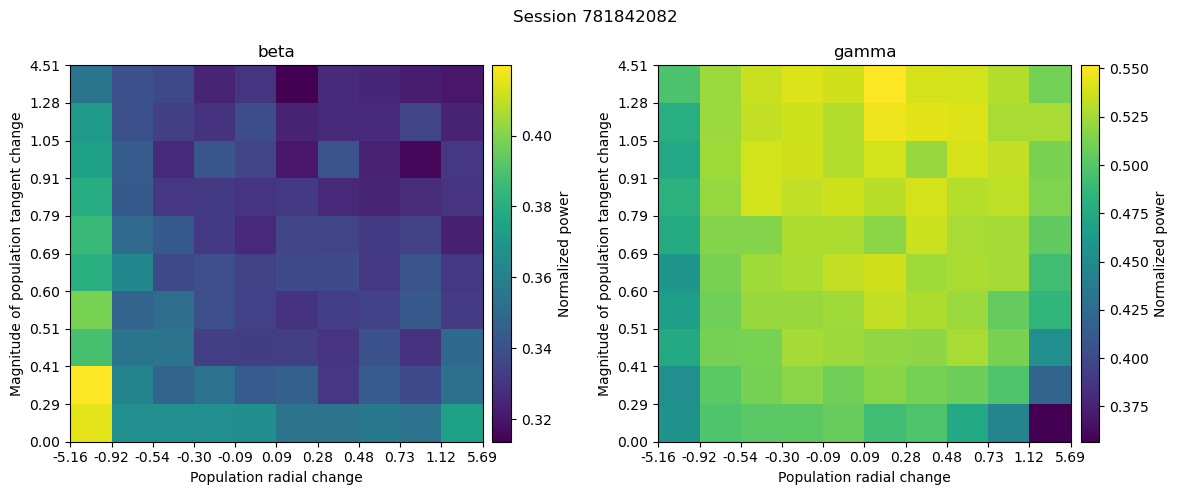

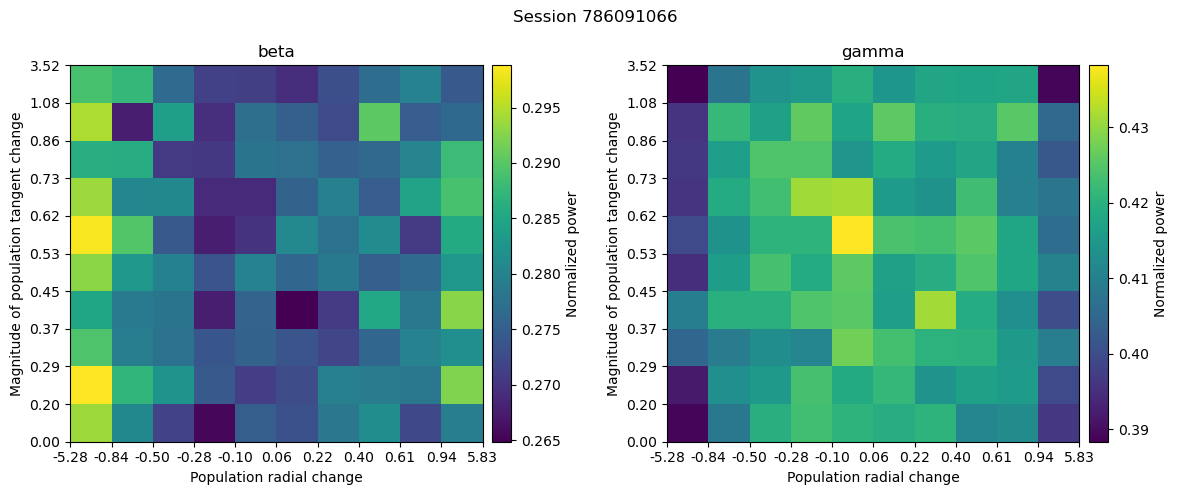

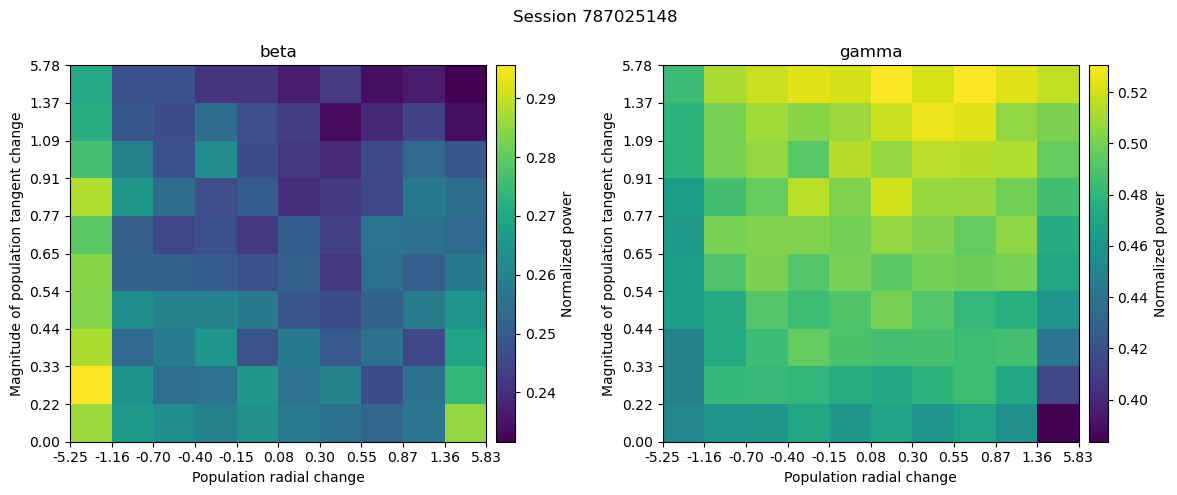

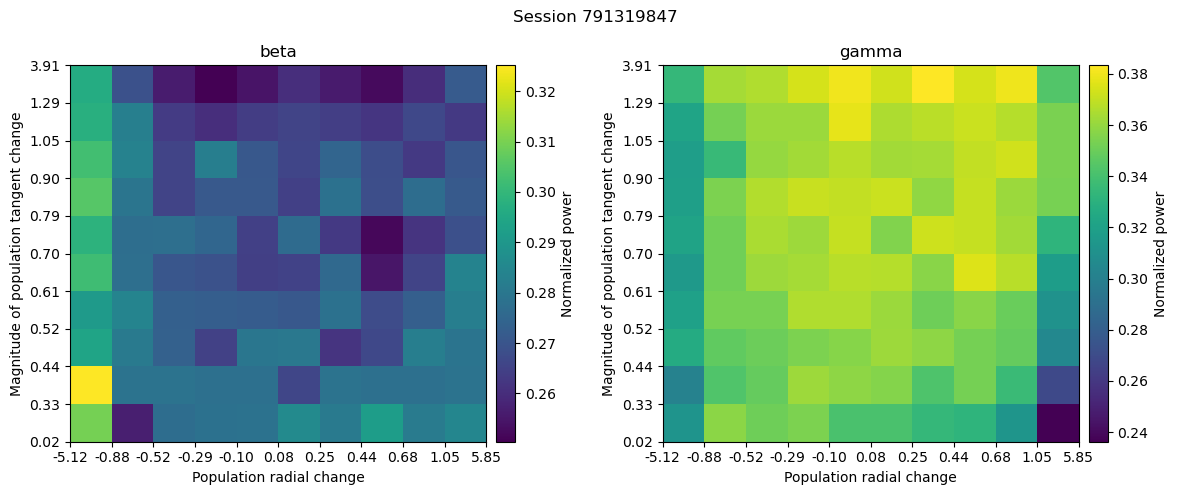

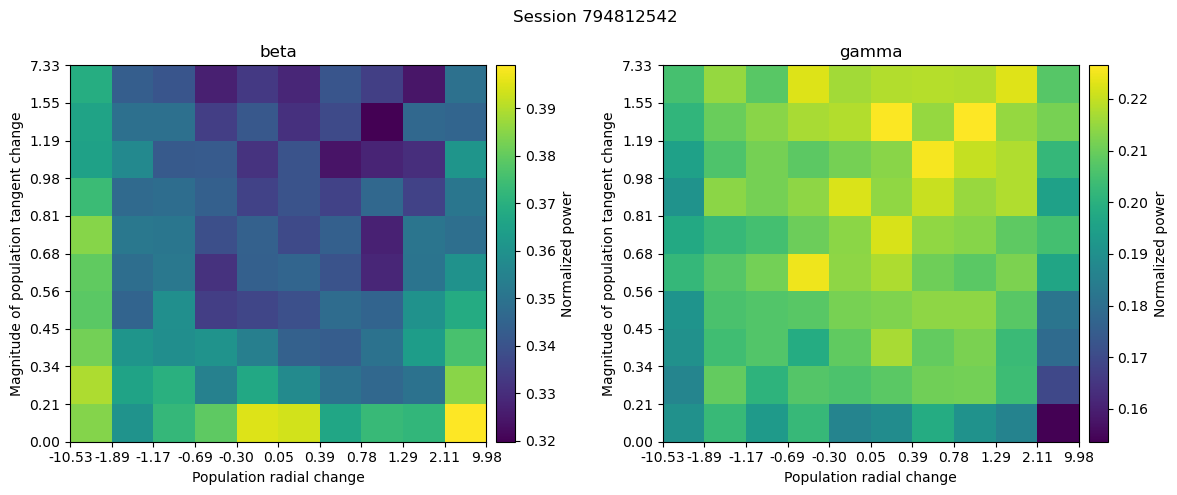

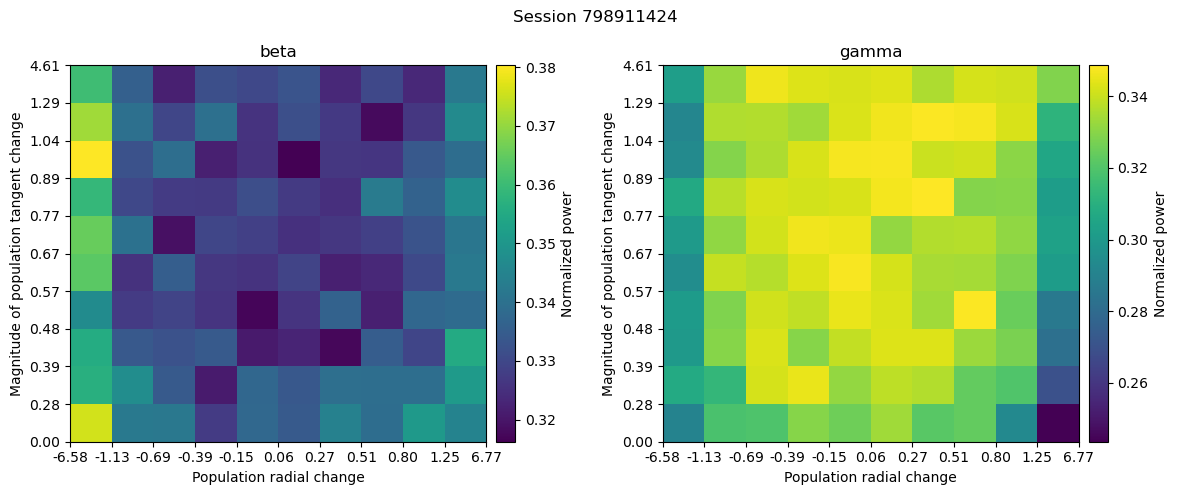

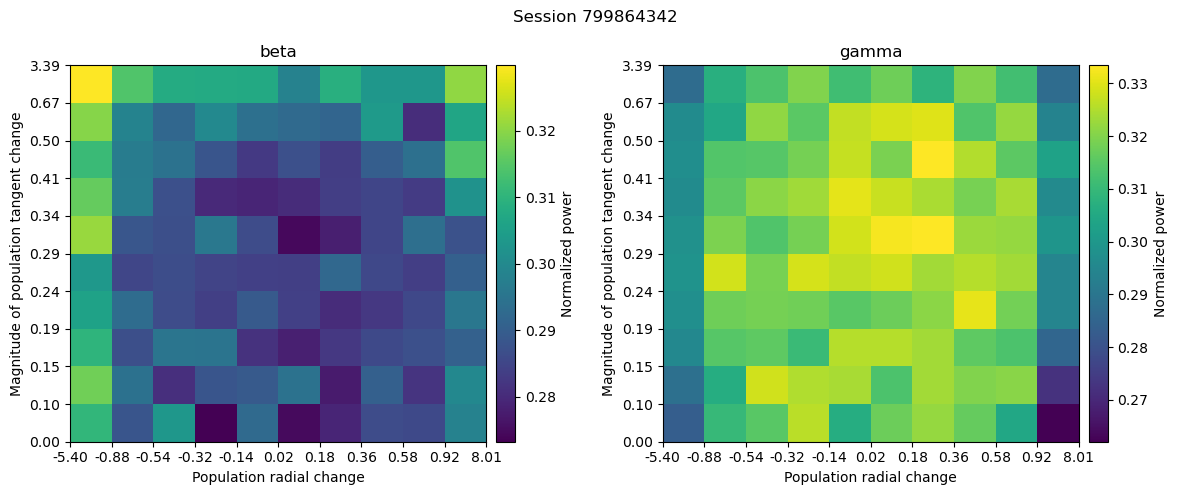

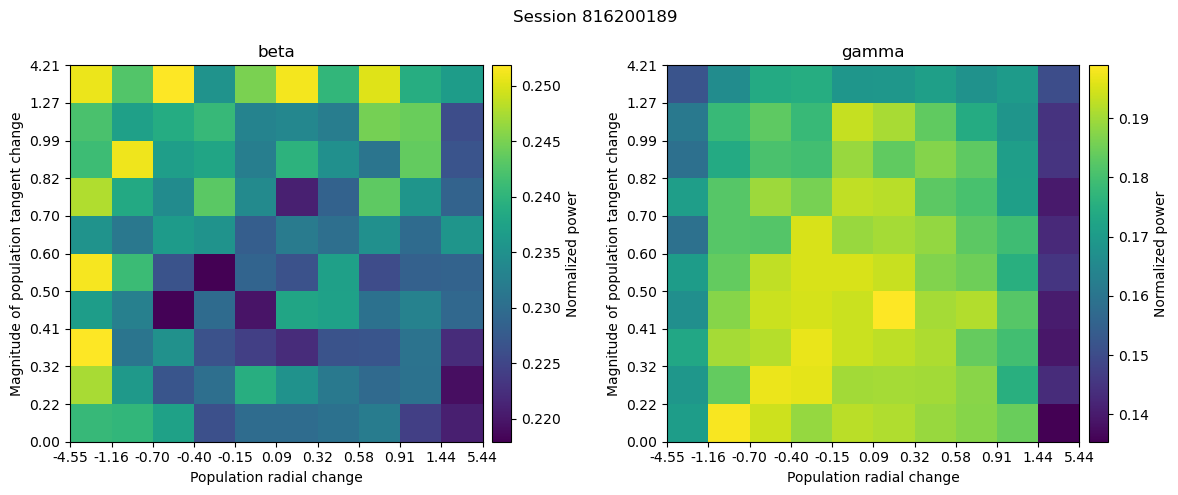

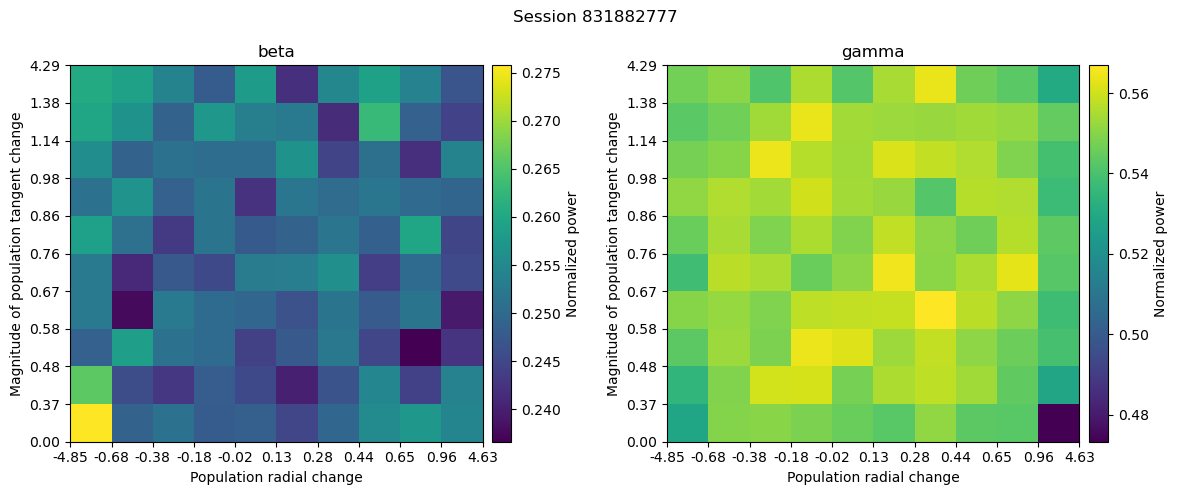

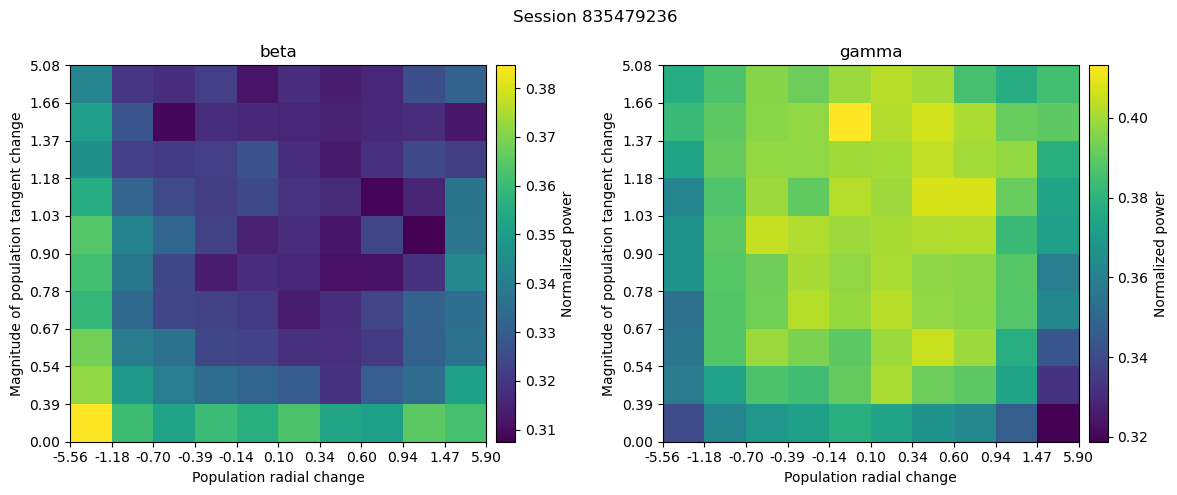

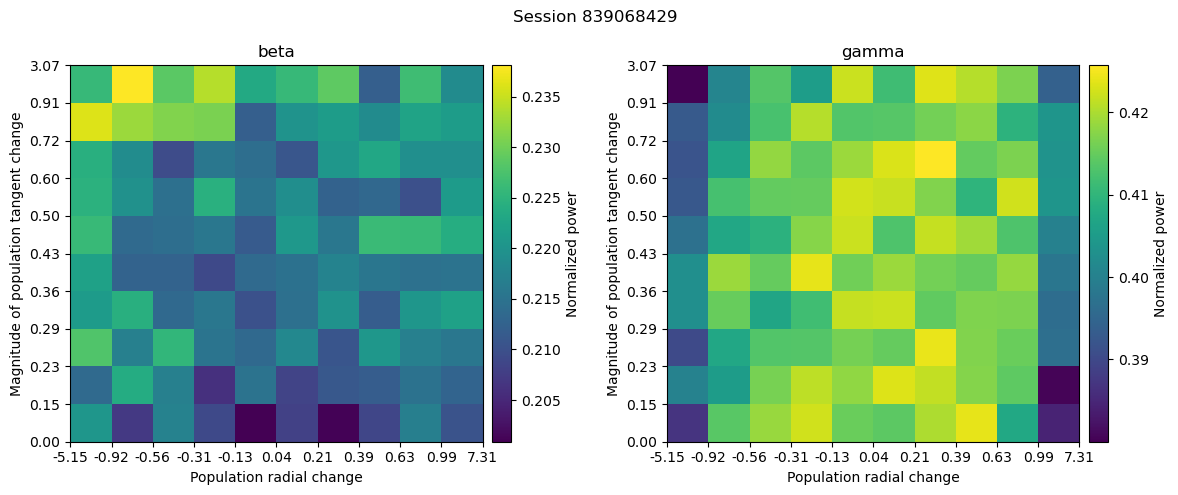

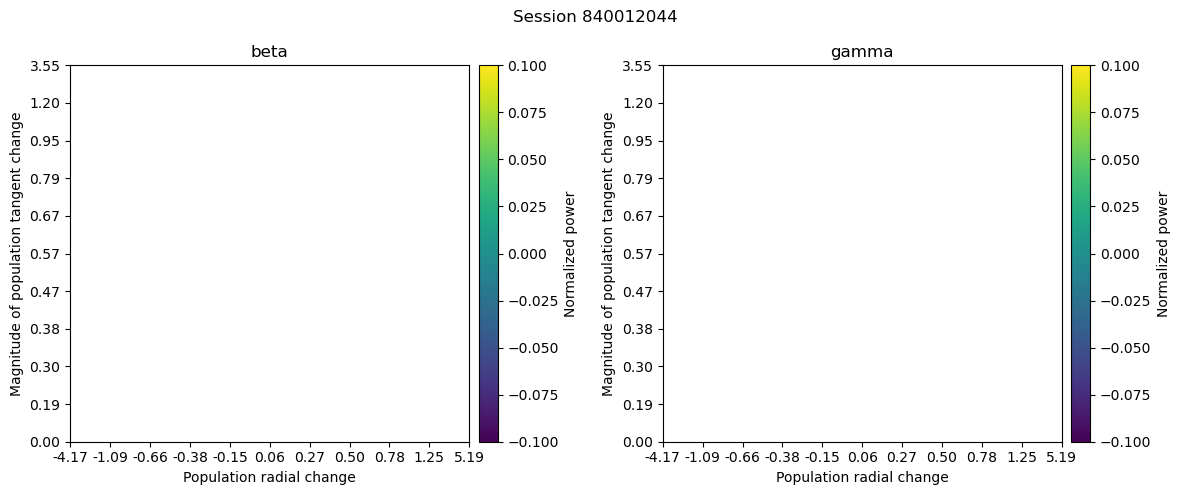

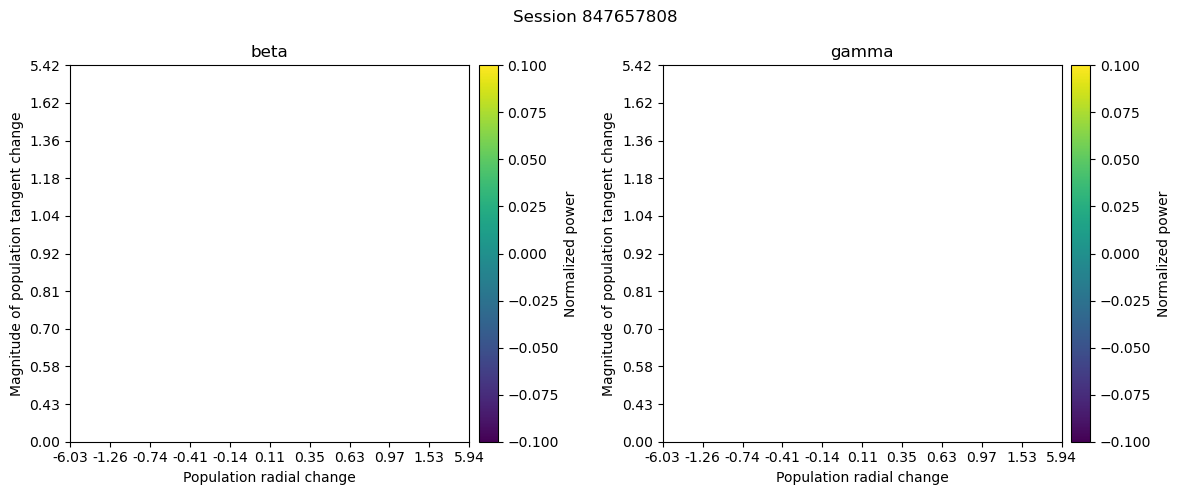

In [10]:
for session_id, ds in heatmap_ds.items():
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    x_bins, y_bins = ds.coords['x_edge'].values, ds.coords['y_edge'].values
    for ax, w in zip(axs, wave_bands):
        pcm, _ = heatmap_in_grid(ds.power.sel(wave_band=w).values, x_bins, y_bins,
            xticks_fmt=xticks_fmt, yticks_fmt=yticks_fmt, even_grid=True, ax=ax)
        plt.colorbar(mappable=pcm, ax=ax, label='Normalized power', pad=0.02)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(w)
    fig.suptitle(f"Session {session_id:d}")
    fig.tight_layout()
plt.show()

### Compile data from all sessions

In [12]:
heatmap_all_ds = xr.concat([ds[['power', 'hist_count']] for ds in heatmap_ds.values()], dim=pd.Index(heatmap_ds, name='session'))
heatmap_all_da = heatmap_all_ds.power
avg_pow = heatmap_all_da.mean(dim='session')  # average

weights = heatmap_all_ds.hist_count
weights = weights / weights.sum(dim=['x_bin', 'y_bin'])  # proportion of bin in each session
weights.values[:, ~weights.values.all(axis=0)] = 1.0  # for bins with no count in all sessions
wgt_avg_pow = heatmap_all_da.weighted(weights).mean(dim='session') # weighted average

unweighted


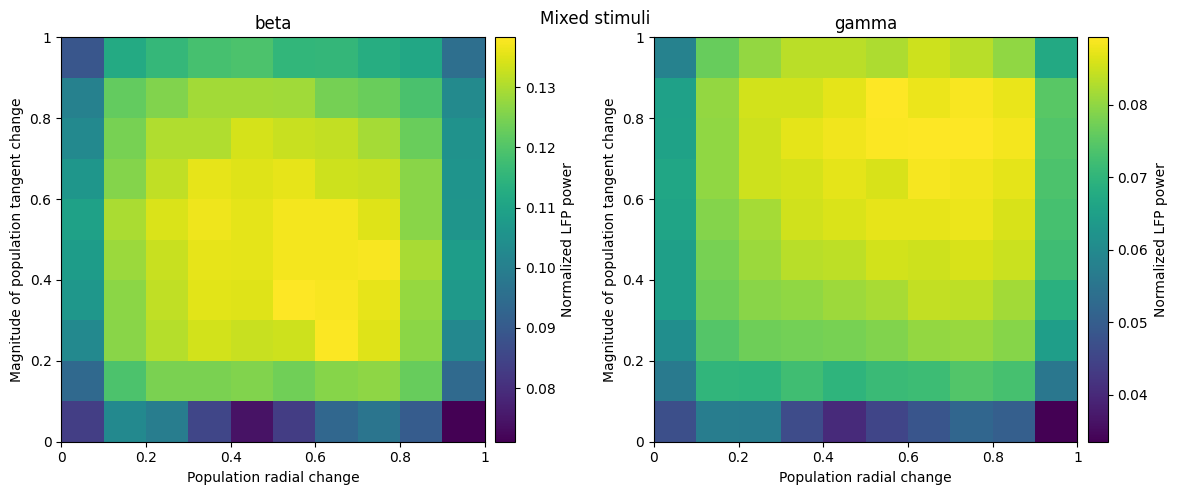

weighted


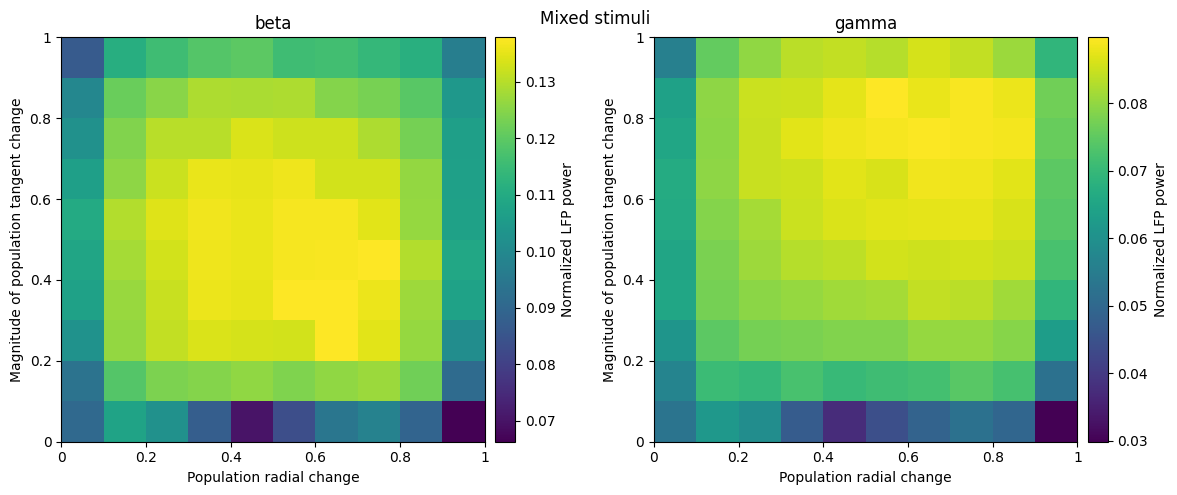

In [13]:
nticks = 6
figsize = (6, 5)
n_iqr = np.array([1.5, 0.6])  # color limit for outlier in term of interquartile

coords = avg_pow.coords
x_bins = np.linspace(0., 1., coords['x_bin'].size + 1)
y_bins = np.linspace(0., 1., coords['y_bin'].size + 1)

for pow, label in zip([avg_pow, wgt_avg_pow], ['unweighted', 'weighted']):
    print(label)
    fig, axs = plt.subplots(1, n_waves, figsize=(n_waves * figsize[0], figsize[1]))
    for ax, w in zip(axs, waves.values):
        C = pow.sel(wave=w).values
        q13 = np.nanquantile(C, [0.25, 0.75])
        vlim = np.clip([np.nanmin(C), np.nanmax(C)], *(q13 + n_iqr * (q13[1] - q13[0]) * np.array([-1, 1])))  # clip outliers
        pcm = heatmap_in_grid(C, x_bins, y_bins, vmax=vlim[1],
            xticks_fmt='{:g}', yticks_fmt='{:g}', even_grid=True, ax=ax)
        ax.get_xaxis().set_major_locator(plt.LinearLocator(numticks=nticks))
        ax.get_yaxis().set_major_locator(plt.LinearLocator(numticks=nticks))
        plt.colorbar(mappable=pcm, ax=ax, label=power_metric, pad=0.02)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(w)
    plt.tight_layout()
    fig.suptitle(stimulus_name.replace('_', ' ').capitalize())
    plt.show()

In [14]:
fig_dir = '../../data/backup/output/figures/'
fig_name = f"power_heatmap_{y_data}-{x_data}_{stimulus_name}"
ext = '.pdf'

savefig_kwargs = dict(
    transparent=True,
    dpi=300.0,
    bbox_inches="tight"
)

In [ ]:
# fig.savefig(os.path.join(fig_dir, fig_name + ext), **savefig_kwargs)